### Colab Activity 10:2: Forecasting with Decomposition Models

You have now seen how to both decompose a time series into seasonal and trend components and how they can be used to forecast into the future using statsmodels.  In this activity, your goal is to identify a new (to you) time series dataset and build a forecast using a seasonal and trend additive or multiplicative model using statsmodels.  You will summarize your findings in an executive brief that explores the following:

- **Data Description**: A high-level overview of your data, its timeframe, and general information on your dataset.
- **Visualizations**: An overview of your findings and conclusions through different types of plots. 
- **Forecast**: A description of the forecast.  Describe the period that was projected and what the forecast says about your data.  Be sure to include presentation-ready plots with appropriate labels and titles.
- **Uncertainty**: Discuss the evaluation of your model on testing data and explore the residuals.  Discuss the consequence of this error for your model and forecasts.  Is there still structure to uncover?  


**Note that the solution code provided below is just an example solution. You are encouraged to manipulate and choose a different dataset than the one shown below and provide questions to generate different results based on your interest.**

Suggested resources for data:

1. [Bureau of Labor Statistics](https://www.bls.gov/): Contains numerous time series such as Consumer Price Index and Inflation indicies.
2. [Kaggle](https://www.kaggle.com/search?q=time+series): Contains numerous time series datasets from different contexts.
3. [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php?format=&task=&att=&area=&numAtt=&numIns=&type=ts&sort=nameUp&view=table): Many time series example datasets.



In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

In [5]:
#Load the dataset
homeSales = pd.read_csv('data/raw_sales.csv')
homeSales

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw_sales.csv'

In [ ]:
# cleanup: convert date column to datetime format, drop unwanted columns
homeSales['datesold'] = pd.to_datetime(homeSales['datesold'])
colsToDrop = ['postcode', 'propertyType']
homeSales2 = homeSales.drop(colsToDrop, axis=1)
homeSales2

,datesold,price,bedrooms
0,2007-02-07,525000,4
1,2007-02-27,290000,3
2,2007-03-07,328000,3
3,2007-03-09,380000,4
4,2007-03-21,310000,3
...,...,...,...
29575,2019-07-25,500000,3
29576,2019-07-25,560000,2
29577,2019-07-26,464950,2
29578,2019-07-26,589000,2


In [ ]:
# Select 2-bedroom sales data (rows) for timeseries analysis
numBedOptions = [2]
sales_2Bed =homeSales2[homeSales2['bedrooms'].isin(numBedOptions)]
sales_2Bed

,datesold,price,bedrooms
45,2007-08-28,325000,2
48,2007-08-30,315000,2
90,2007-11-08,497000,2
92,2007-11-12,465000,2
123,2007-12-14,259000,2
...,...,...,...
29574,2019-07-25,475000,2
29576,2019-07-25,560000,2
29577,2019-07-26,464950,2
29578,2019-07-26,589000,2


In [ ]:
sales_2Bed = sales_2Bed.drop('bedrooms', axis=1)
sales_2Bed

,datesold,price
45,2007-08-28,325000
48,2007-08-30,315000
90,2007-11-08,497000
92,2007-11-12,465000
123,2007-12-14,259000
...,...,...
29574,2019-07-25,475000
29576,2019-07-25,560000
29577,2019-07-26,464950
29578,2019-07-26,589000


In [ ]:
# convert datesold to monthly, so that we get periodic data
sales_2Bed['datesold'] = sales_2Bed['datesold'].dt.to_period('m')

In [ ]:
sales_2Bed.head(5)

,datesold,price
45,2007-08,325000
48,2007-08,315000
90,2007-11,497000
92,2007-11,465000
123,2007-12,259000


In [ ]:
# The data contains multiple rows with the same dates (each sale is recorded, and there could be multiple sales per day and definitely per month).
# Group the data by group and then average to get the average sales price per unique month
sales_2Bed_grouped = sales_2Bed.groupby('datesold').mean()
sales_2Bed_grouped

,price
datesold,
2007-06,300000.000000
2007-07,330000.000000
2007-08,320000.000000
2007-09,401800.000000
2007-10,405000.000000
...,...
2019-03,398793.750000
2019-04,431436.309524
2019-05,489565.517241


In [ ]:
# Save the above dataframe so that first of the month can be added to the data by hand
# example: 2007-06 --> 2007-06-01
# This is because STL does not seem to recognize month-only timestamps and throws an error
sales_2Bed_grouped.to_csv('data/sales-monthly.csv')

In [ ]:
#Load the hand-modified dataset
homeSales = pd.read_csv('data/sales-monthly.csv')
homeSales

,datesold,price
0,2007-06,300000.000000
1,2007-07,330000.000000
2,2007-08,320000.000000
3,2007-09,401800.000000
4,2007-10,405000.000000
...,...,...
141,2019-03,398793.750000
142,2019-04,431436.309524
143,2019-05,489565.517241
144,2019-06,482085.294118


In [ ]:
homeSales['datesold'] = pd.to_datetime(homeSales['datesold'])

In [ ]:
sales1 = homeSales.set_index('datesold')
sales1

,price
datesold,
2007-06-01,300000.000000
2007-07-01,330000.000000
2007-08-01,320000.000000
2007-09-01,401800.000000
2007-10-01,405000.000000
...,...
2019-03-01,398793.750000
2019-04-01,431436.309524
2019-05-01,489565.517241


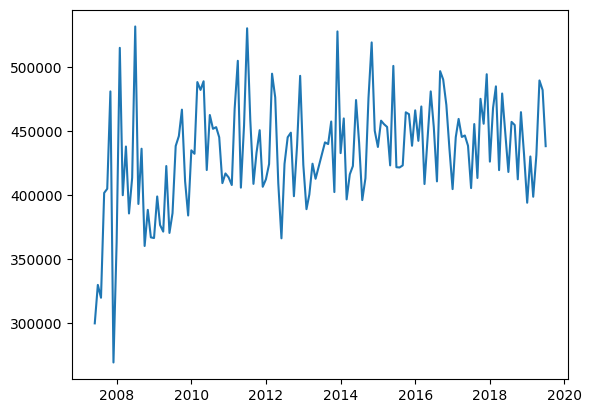

In [ ]:
plt.plot(sales1)

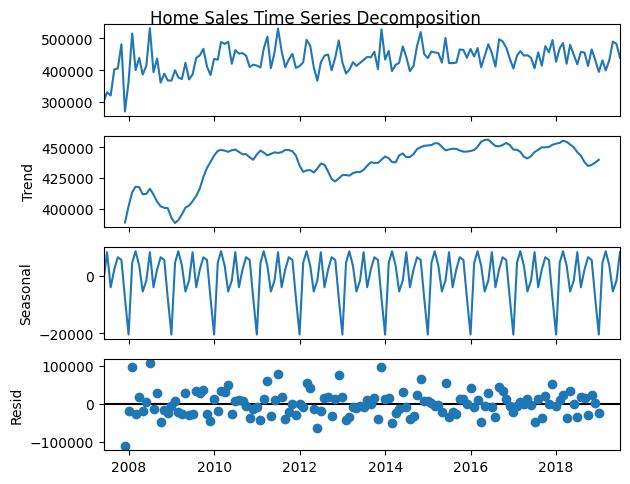

In [ ]:
sales1_decomp = seasonal_decompose(sales1)
fig_decomp = sales1_decomp.plot()
fig_decomp.suptitle("Home Sales Time Series Decomposition",  y='1')
fig_decomp.savefig("SalesDecomp.png")

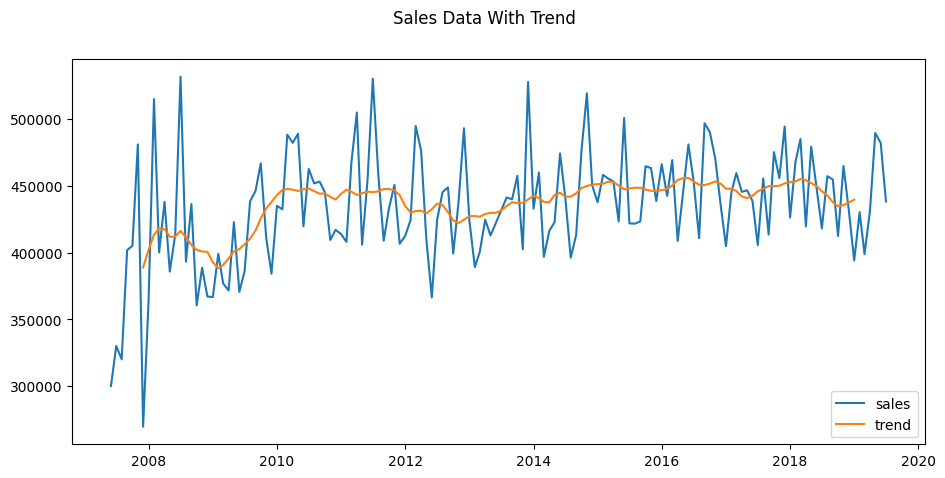

In [ ]:
trend_sales = sales1_decomp.trend
plt.figure(figsize=(11,5))
plt.plot(sales1, label ='sales')
plt.plot(trend_sales, label = 'trend')
plt.legend(loc='lower right')
plt.suptitle('Sales Data With Trend')
plt.show()
#plt.savefig("DataWithTrend.png")

In [ ]:
y_hist = sales1[:'2015-12-01']
y_future = sales1['2016-01-01':]

In [ ]:
print(y_hist.shape)
print(y_future.shape)
print(y_hist.tail())
print(y_future.head())
print(type(y_hist))

(103, 1)
(43, 1)
                    price
datesold                 
2015-08-01  421630.769231
2015-09-01  423274.193548
2015-10-01  464688.679245
2015-11-01  463242.424242
2015-12-01  438585.526316
                    price
datesold                 
2016-01-01  466214.285714
2016-02-01  442432.000000
2016-03-01  469246.666667
2016-04-01  408721.621622
2016-05-01  444380.952381
<class 'pandas.core.frame.DataFrame'>


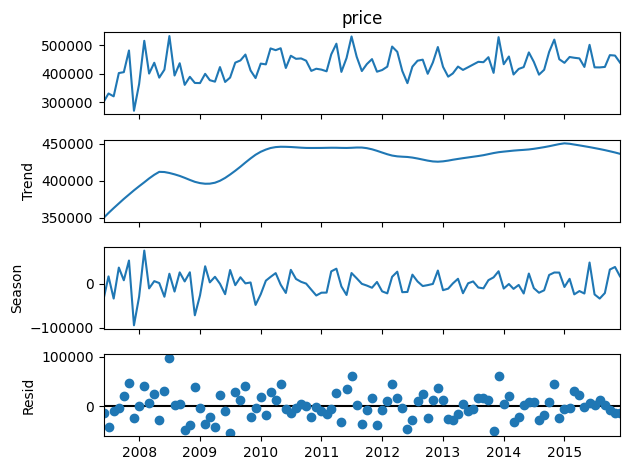

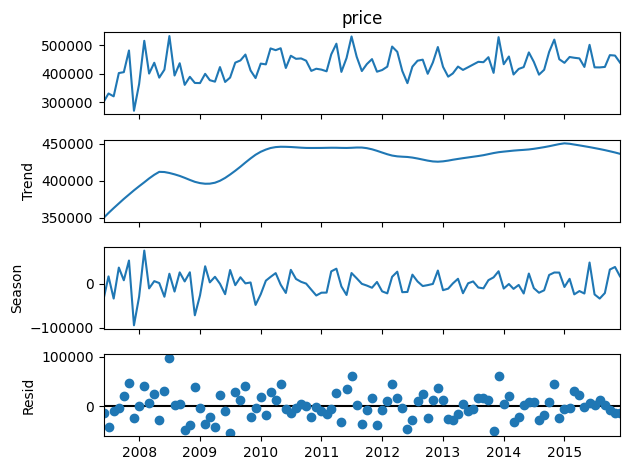

In [ ]:
# decomposition
stl = STL(y_hist['price'])
results = stl.fit()
trend = results.trend
results.plot()

In [ ]:
# Now for the time series analysis
stlf = STLForecast(y_hist['price'], ARIMA, seasonal=7, model_kwargs={'order':(1, 1, 0), 'trend':"t"})

# Fit model using historical data
stlf_results = stlf.fit()

#produce forecast for future data
forecast = stlf_results.forecast(len(y_future['price']))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


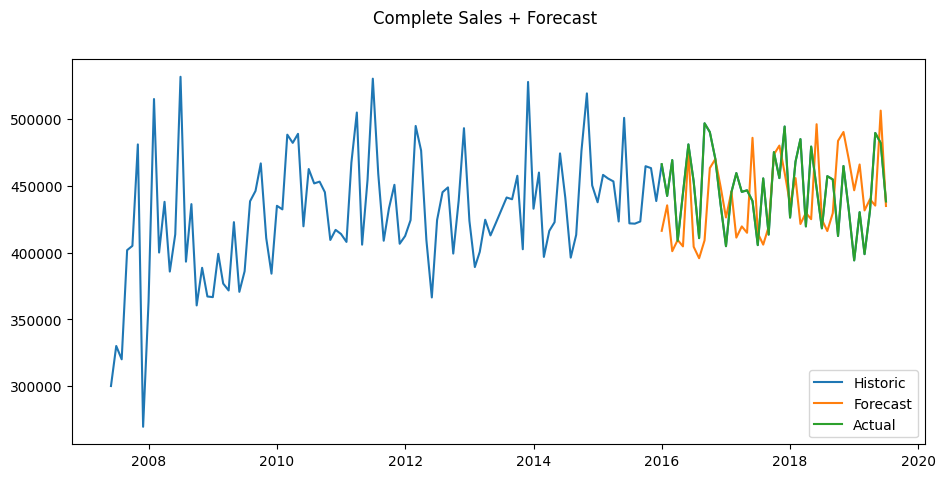

In [ ]:
plt.figure(figsize=(11,5))
plt.plot(sales1, label='Historic')
plt.plot(forecast, label='Forecast')
plt.plot(y_future, label = "Actual")
plt.legend(loc='lower right')
plt.suptitle('Complete Sales + Forecast')
plt.show()
#plt.savefig("FullSalesAndForecast.png")

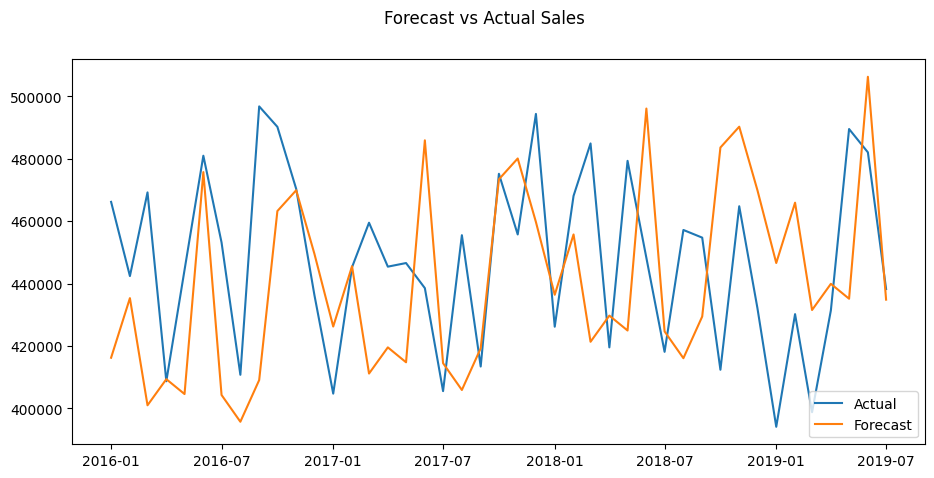

In [ ]:
plt.figure(figsize=(11,5))
plt.plot(y_future, label = "Actual")
plt.plot(forecast, label='Forecast')
plt.legend(loc='lower right')
plt.suptitle('Forecast vs Actual Sales')
plt.show()
#plt.savefig("ForecastVsActual.png")